# Regrid NOAA CDR product to global AVHRR snow product

NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1 (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00756)

## Import packages
conda env: `phd_v3` (in `envs/phd`: https://github.com/mickaellalande/PhD/tree/master/envs/phd)

In [21]:
import xarray as xr
import numpy as np
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures

## Open NOAA CDR

In [23]:
ds = xr.open_dataset('data/nhsce_v01r01_19661004_20201005.nc').sel(time=slice('1982','2020'))
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    da = ds.snow_cover_extent.where(ds.land == 1)*100   
da.attrs['units'] = '%'
da = da.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

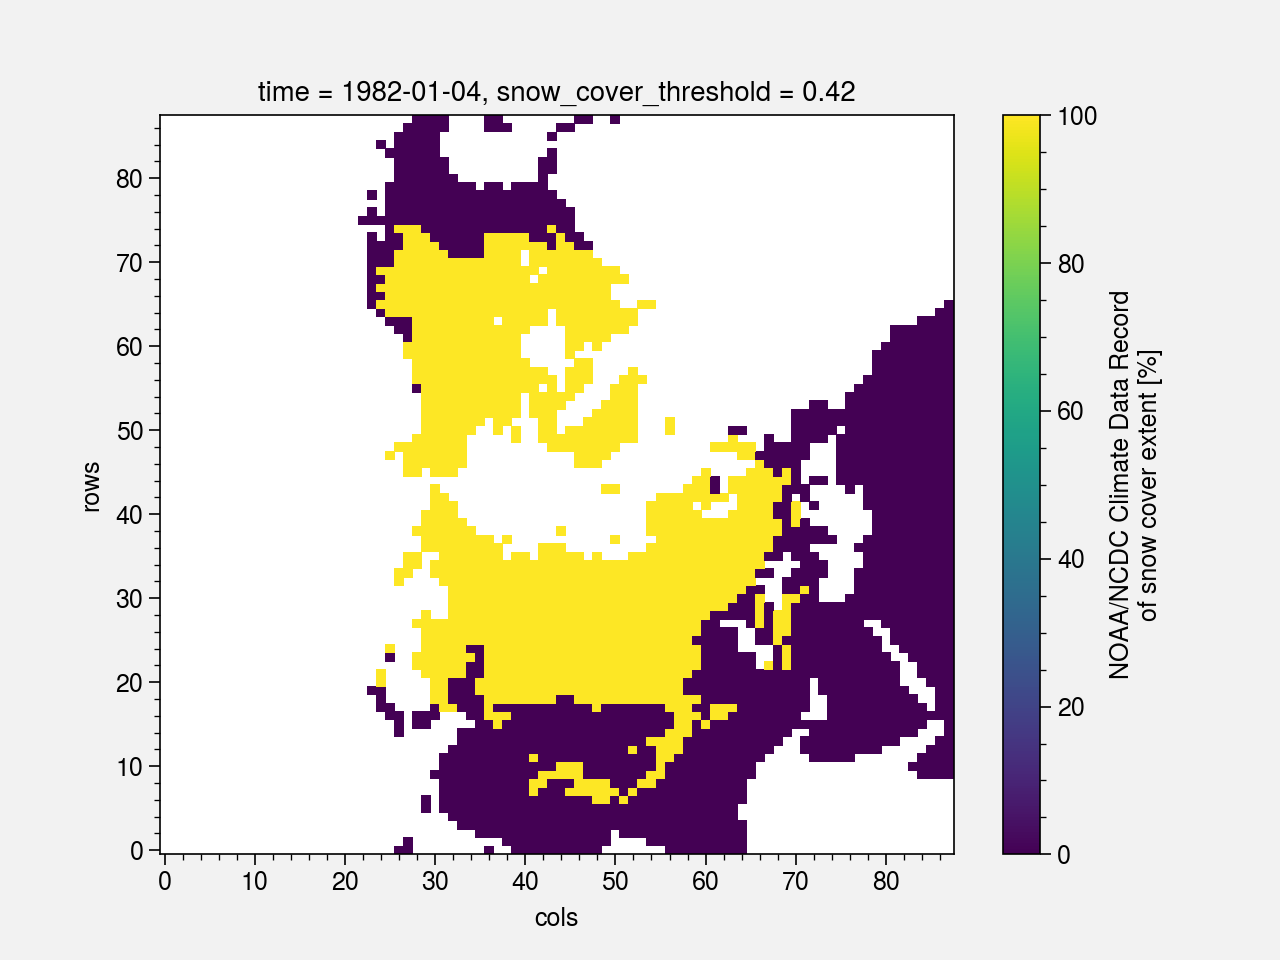

In [24]:
da[0].plot()

## Open grid

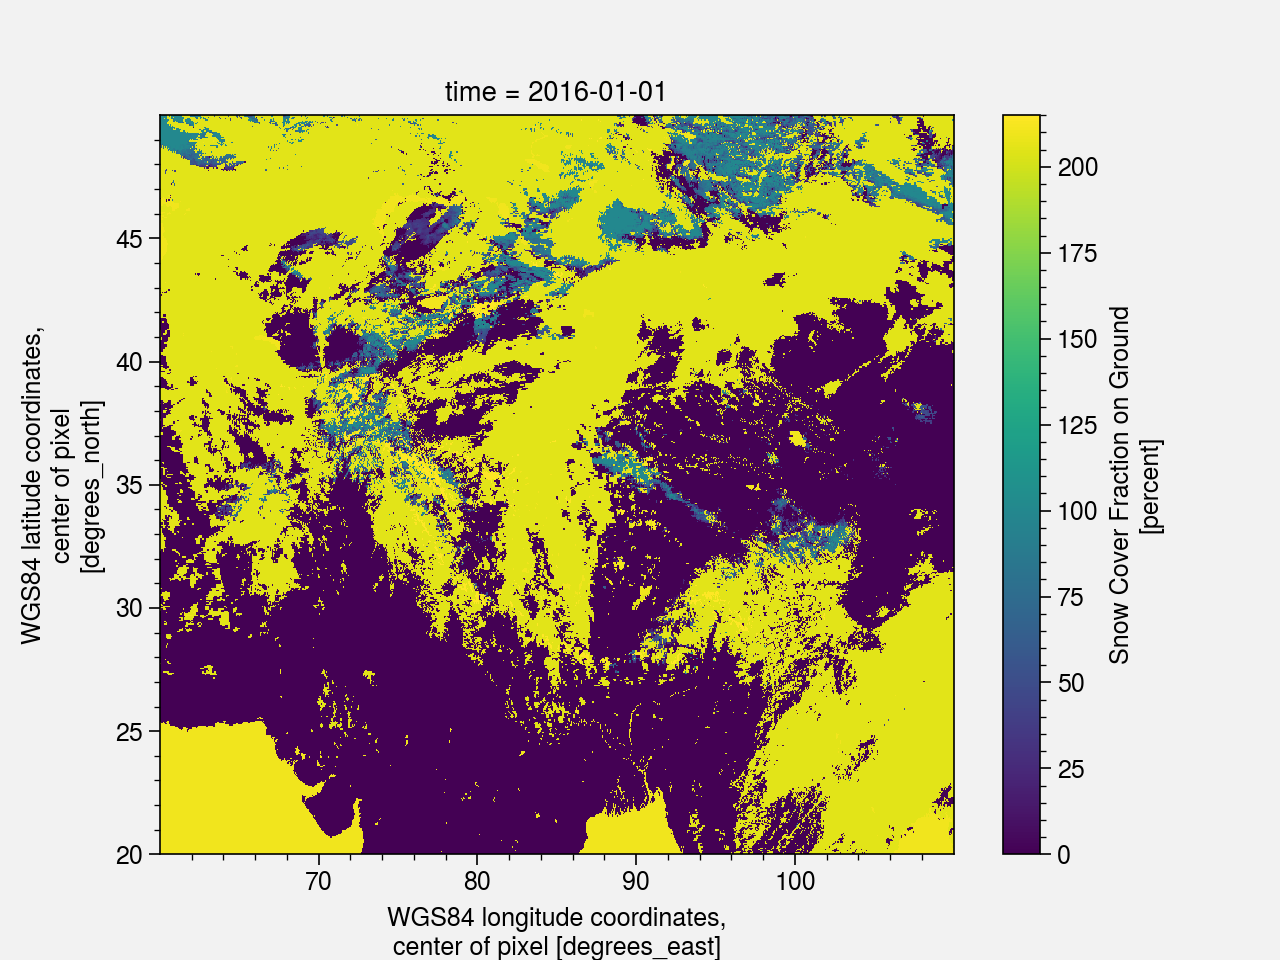

In [26]:
grid = xr.open_dataset('data/20160101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0.nc').sel(lat=slice(20,50), lon=slice(60,110))
grid.scfg[0].plot()

## Regrid

In [27]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(da, grid, 'bilinear', periodic=False, reuse_weights=True) 
# period should be True for global data but because of stereographic projection it doesn't work here

regridder = add_matrix_NaNs(regridder)
da_regrid = regridder(da)

Create weight file: bilinear_88x88_600x1000.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


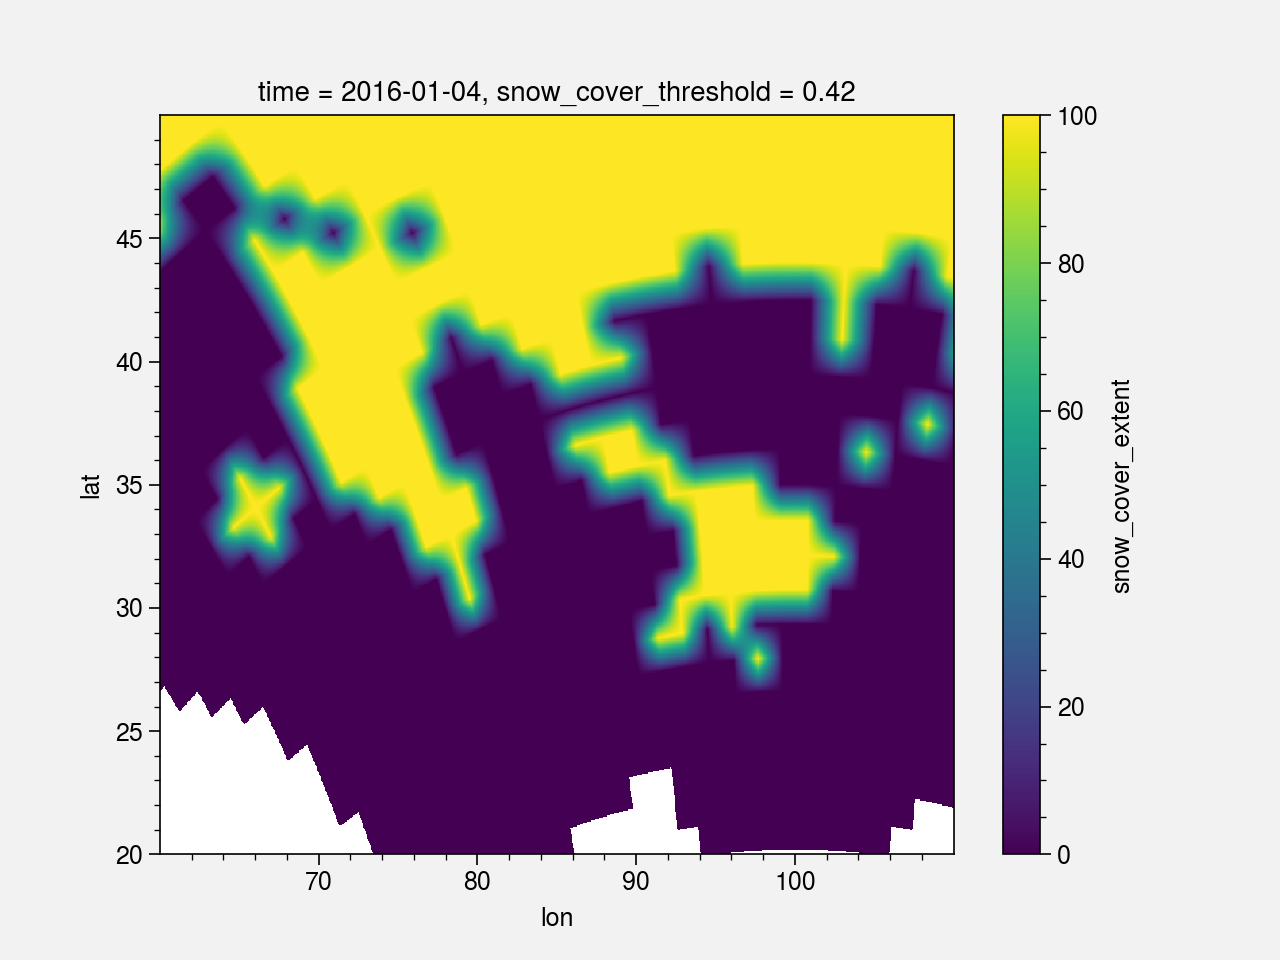

In [37]:
da_regrid.sel(time='2016-01-01', method='nearest').plot()

In [44]:
grid.scfg[0]

<xarray.DataArray 'scfg' (lat: 600, lon: 1000)>
[600000 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2016-01-01
  * lat      (lat) float64 20.02 20.08 20.12 20.17 ... 49.83 49.88 49.92 49.97
  * lon      (lon) float64 60.03 60.08 60.12 60.17 ... 109.8 109.9 109.9 110.0
Attributes:
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    grid_mapping:         spatial_ref
    long_name:            Snow Cover Fraction on Ground
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfg_unc

In [46]:
da_regrid.sel(time='2016-01-01', method='nearest')

<xarray.DataArray 'snow_cover_extent' (lat: 600, lon: 1000)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
    time                  datetime64[ns] 2016-01-04
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float64 60.03 60.08 60.12 ... 109.9 109.9 110.0
  * lat                   (lat) float64 20.02 20.08 20.12 ... 49.88 49.92 49.97
Attributes:
    regrid_method:  bilinear

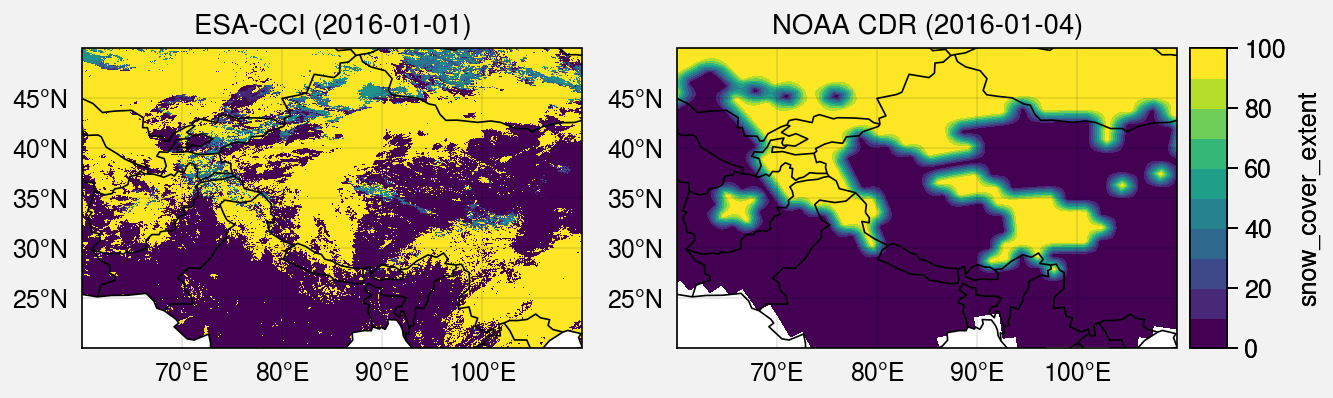

In [59]:
fig, axs = plot.subplots(nrows=1, ncols=2, proj='cyl')
cmap = 'viridis'

axs[0].pcolormesh(grid.scfg[0], cmap=cmap)
axs[0].format(title='ESA-CCI (2016-01-01)')

axs[1].pcolormesh(da_regrid.sel(time='2016-01-01', method='nearest'), cmap=cmap, colorbar='r')
axs[1].format(title='NOAA CDR (2016-01-04)')

axs.format(
    latlim=(20, 50), lonlim=(60,110),
    labels=True, borders=True, coast=True, ocean=True
)

## Save

In [62]:
da_regrid.nbytes

9710400000

In [69]:
da_regrid.to_netcdf('/home/lalandmi/data/esacci/nhsce_v01r01_1982-2020_5km.nc')